In [113]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import torch
import bbobtorch
import torch
import model 
# import losses
#from botorch.models import SingleTaskGP
#from botorch.fit import fit_gpytorch_mll
#from botorch.utils import standardize+
# from gpytorch.mlls import ExactMarginalLogLikelihood
import gt_sampling
import torch.optim as optim
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from utils.soft_dtw import SoftDTW

import torch
# import torch.nn as nn
# import torch.nn.functional as F
from utils.utils import plot_simulated_meshgrid, plot_collage
import torch.distributions as dist
# from bayes_opt import BayesianOptimization
# from bayes_opt import BayesianOptimization
# from bayes_opt import UtilityFunction
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import gridspec

sys.path.append("../misc")
import bbob_deferential as bobby



In [114]:
# create ground truth functions
n_dim = 2
samples = 1000
seed = 42

def create_problem(f_number, n_dim, seed):
    if f_number == 1:
        problem = bbobtorch.create_f01(n_dim, seed=seed)
    elif f_number == 3:
        problem = bobby.create_f03(n_dim, seed=seed)
    elif f_number == 24:
        problem = bobby.create_f24(n_dim, seed=seed)

    return problem

problem_f01 = create_problem(1, n_dim, seed)
problem_f03 = create_problem(3, n_dim, seed)
problem_f24 = create_problem(24, n_dim, seed)
problem_f00 = lambda x: (1/4*x**2-1/2*x).sum(dim=1, keepdim=True)

In [115]:
# sampling from groundtruth functions
sample_f01 = gt_sampling.get_sample(problem_f01, n_samples=samples, n_dim=2, seed=42, method='random', )
sample_f03 = gt_sampling.get_sample(problem_f03, n_samples=samples, n_dim=2, seed=42, method='random',)
sample_f24 = gt_sampling.get_sample(problem_f24, n_samples=samples, n_dim=2, seed=42, method='random',)
sample_f00 = gt_sampling.get_sample(problem_f00, n_samples=samples, n_dim=2, seed=42, method='random',)

c:\Users\Pascal\OneDrive - bwedu\Python Shit\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()


In [116]:
X_input_24, _, _ , _  = sample_f24

In [117]:
X_input_24

tensor([[-1.2546,  4.5071],
        [ 2.3199,  0.9866],
        [-3.4398, -3.4401],
        ...,
        [ 2.5138,  1.5696],
        [ 4.5661, -4.3104],
        [-4.4295, -2.1781]])

## Simulate the function with NN

In [118]:
# simulate the function with the aboth samples and results|
X_input, _, real_d_1, real_d_2 = sample_f00
y_input = sample_f00[1].float()            

# transform numpy arrays to torch tensors
X_input = torch.tensor(X_input, dtype=torch.float32, requires_grad=True)
real_d_1 = torch.tensor(real_d_1, dtype=torch.float32, requires_grad=True)
real_d_2 = torch.tensor(real_d_2, dtype=torch.float32, requires_grad=True)

C:\Users\Pascal\AppData\Local\Temp\ipykernel_62956\2808505799.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_input = torch.tensor(X_input, dtype=torch.float32, requires_grad=True)


In [119]:
X_input.mean()

tensor(-0.0136, grad_fn=<MeanBackward0>)

In [120]:
class CustomNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        x = self.layers(x)
        y = x[:, 0]  # Output y value
        
        # Compute first and second derivatives
        x_grad = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        y_grad = x_grad[:, 0]  # First derivative
        y_grad2 = torch.autograd.grad(outputs=y_grad, inputs=x, grad_outputs=torch.ones_like(y_grad), create_graph=True)[0][:, 0]  # Second derivative
        
        return y, y_grad, y_grad2

In [121]:
class CustomLoss(torch.nn.Module):
    def __init__(self, y_weight, first_derivative_weight, second_derivative_weight):
        super(CustomLoss, self).__init__()
        self.y_weight = y_weight
        self.first_derivative_weight = first_derivative_weight
        self.second_derivative_weight = second_derivative_weight
        
    def forward(self, predicted_y, predicted_first_derivative, predicted_second_derivative, target_y, target_first_derivative, target_second_derivative):
        loss_y = torch.nn.MSELoss()(predicted_y, target_y)
        loss_first_derivative =torch. nn.MSELoss()(predicted_first_derivative, target_first_derivative)
        loss_second_derivative = torch.nn.MSELoss()(predicted_second_derivative, target_second_derivative)
        
        total_loss = (
            self.y_weight * loss_y +
            self.first_derivative_weight * loss_first_derivative +
            self.second_derivative_weight * loss_second_derivative
        )
        return total_loss

In [186]:
def higher_order_derivatives(f, wrt, n):
    derivatives = []
    for f_ in f:
        derivatives.append(f_.mean())
        for _ in range(n):
            grads = torch.autograd.grad(f_, wrt, create_graph=True)[0]
            derivatives.append(grads.mean())
            f_ = grads.mean()
    return torch.stack(derivatives)


class KnollHaZeHei(torch.nn.Module):
    def __init__(self, diff_degree, criterion):
        super().__init__()
        self.diff_degree = diff_degree
        self.criterion = criterion

    def forward(self, pred, true, x):
        true = higher_order_derivatives(true, x, self.diff_degree)
        pred = higher_order_derivatives(pred, x, self.diff_degree)
        loss = self.criterion(pred, true)
        return loss



In [187]:
input_dim = 2
hidden_dim = 8
hidden_layers = 4
output_dim = 1
learning_rate = 0.01
num_epochs = 100
bs = 1024

m = model.NN(input_dim, hidden_dim, hidden_layers, torch.nn.ReLU())#CustomNetwork(input_dim, hidden_dim, hidden_layers)
optimizer = optim.SGD(m.parameters(), lr=learning_rate)
criterion = KnollHaZeHei(3, torch.nn.MSELoss()) #CustomLoss(y_weight, first_derivative_weight, second_derivative_weight)#torch.nn.MSELoss()# 

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    x = X_input.clone().detach().requires_grad_(True)
    x = x[torch.randperm(samples)][:bs]
    optimizer.zero_grad()
    trues =  (bobby.create_f24(input_dim)(x)+300.)/250.
    #preds, pred_d_1, pred_d_2 = m(x)
    pred = m(x)

    Karloss = criterion(trues, pred, x)#preds, pred_d_1, pred_d_2, trues, real_d_1, real_d_2) # XXX add real derivatives for loss
    # Backward and optimize
    Karloss.backward()
    optimizer.step()
    # if Karloss < 1 and epoch > 100:
    #     break
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Karloss.item():.4f}')

Epoch [10/100], Loss: 0.0023
Epoch [20/100], Loss: 0.0397


KeyboardInterrupt: 

In [188]:

# generate mesh grid for plotting
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 100)
    y = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(x, y)
    mesh_samples = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_results = m(mesh_samples_tensor).reshape(X.shape)

<Axes: title={'center': 'Simulated Function from NN'}, xlabel='X1', ylabel='X2'>

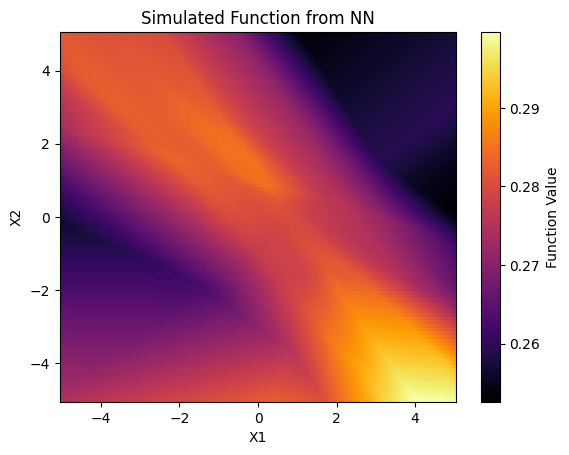

In [189]:
plot_simulated_meshgrid(X, Y, mesh_results, model='NN')


<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

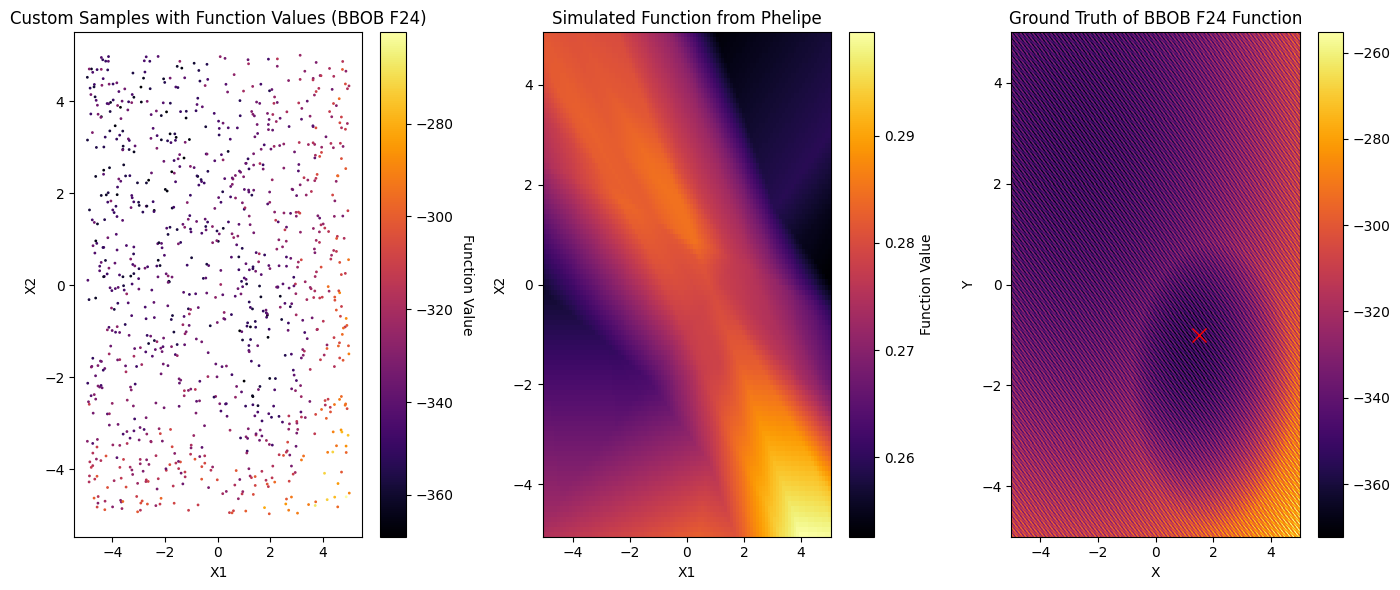

In [190]:
plot_collage(sample_f24[0].detach().numpy(), sample_f24[1].detach().numpy(), problem_f24, "BBOB F24", "Phelipe", X, Y, mesh_results)
#samples, results, problem, problem_name, model_name, X, Y, mesh_results

## Simulation with Monte Carlo Simulation


XXX until now just taken from the internet

In [ ]:
# Use Gaussian Process Regression to approximate the function
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the Gaussian Process Regression model to the Monte Carlo samples
gpr_model.fit(monte_carlo_samples, monte_carlo_results)

# Generate a mesh grid for plotting the approximated function
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)
mesh_samples = np.c_[X.ravel(), Y.ravel()]

# Predict function values using the GPR model on the mesh grid
mesh_results, _ = gpr_model.predict(mesh_samples, return_std=True)
mesh_results = mesh_results.reshape(X.shape)

NameError: name 'monte_carlo_samples' is not defined

In [ ]:
plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", X, Y, mesh_results)

TypeError: plot_collage() missing 1 required positional argument: 'mesh_results'

## Simulation with Support Vector Regression

In [ ]:
from sklearn.svm import SVR

In [ ]:
# simulate the function with the aboth samples and results
X_svc = X_input
y_svc = y_input.float()
model_name = "SVR Model"

In [ ]:
# define svr model
# XXX parameters are not optimized
svr_model = SVR(kernel='rbf', C=4.0, epsilon=0.6)

# Fit the SVR model to the Monte Carlo samples
svr_model.fit(X_svc, y_svc)


SVR(C=4.0, epsilon=0.6)

In [ ]:
#Generate a mesh grid for plotting the approximated function
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)
mesh_samples = np.c_[X.ravel(), Y.ravel()]

# Predict function values using the SVR model on the mesh grid
mesh_results = svr_model.predict(mesh_samples)
mesh_results = mesh_results.reshape(X.shape)

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

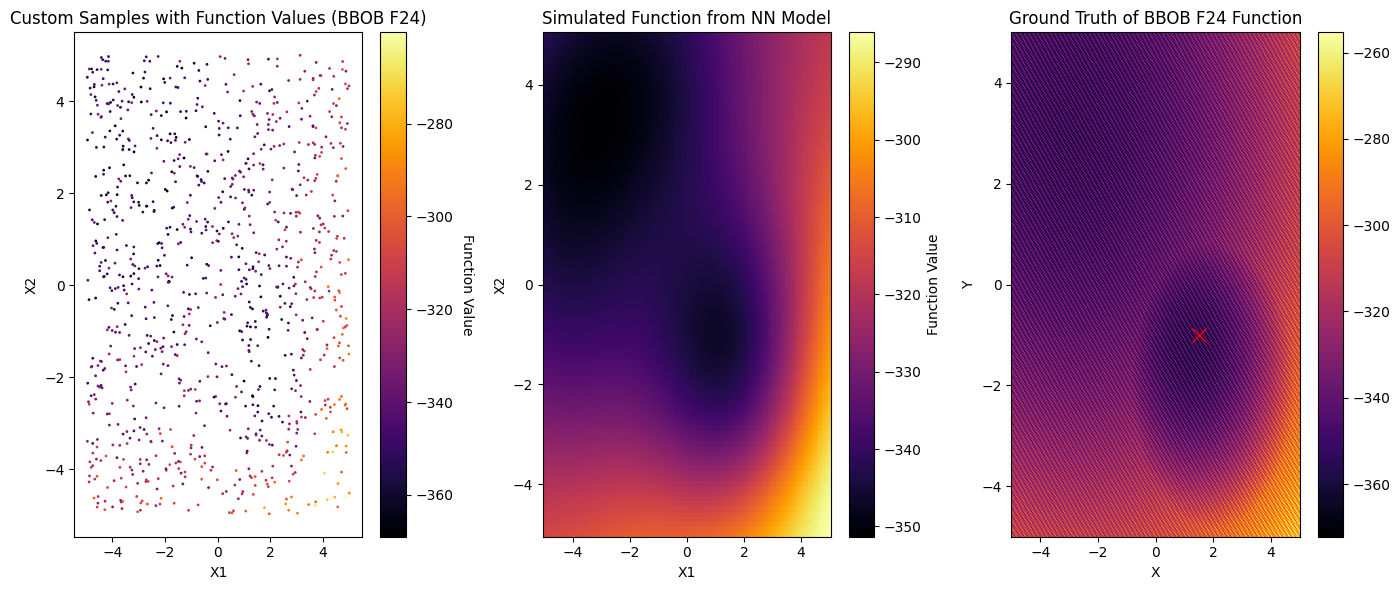

In [ ]:
plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", X, Y, mesh_results)

C:\Users\Pascal\AppData\Local\Temp\ipykernel_29988\981844319.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  edge_index = torch.tensor(kneighbors_graph(points, k, mode='connectivity').toarray().nonzero(), dtype=torch.long)


Epoch [100/1000], Loss: 44848196.0
Epoch [200/1000], Loss: 31076618.0
Epoch [300/1000], Loss: 16631369.0
Epoch [400/1000], Loss: 9497599.0
Epoch [500/1000], Loss: 7926166.0
Epoch [600/1000], Loss: 7696048.5
Epoch [700/1000], Loss: 7576297.0
Epoch [800/1000], Loss: 7452859.0
Epoch [900/1000], Loss: 7321326.5
Epoch [1000/1000], Loss: 7181539.0


ValueError: `MessagePassing.propagate` only supports integer tensors of shape `[2, num_messages]`, `torch_sparse.SparseTensor` or `torch.sparse.Tensor` for argument `edge_index`.

In [ ]:
# generate mesh grid for plotting
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 100)
    y = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(x, y)
    mesh_samples = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_results = model(mesh_samples_tensor).reshape(X.shape)

AttributeError: 'Tensor' object has no attribute 'x'

In [ ]:
plot_simulated_meshgrid(X, Y, mesh_results, model='NN')

In [ ]:
!pip install torch_geometric

                                              0.0/661.6 kB ? eta -:--:--
     -----                                   92.2/661.6 kB 5.1 MB/s eta 0:00:01
     ------------------------               430.1/661.6 kB 5.4 MB/s eta 0:00:01
     -------------------------------------- 661.6/661.6 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910499 sha256=b4fbdef4bacbdfed17dfc8c56dca16fcba07d024d0302abeb7029fdf52c9e673
  Stored in directory: c:\users\pascal\appdata\local\pip\cache\wheels\ac\dc\30\e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
  Using cached torch_ge